# SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
seed = 45

## Data generation

In [34]:
from sklearn.datasets import make_moons

data_x, data_y = make_moons(n_samples=500, noise=0.1, random_state=seed)
data_s = [0.3 if x[0] < 1 and y == 1 else 1 for x, y in zip(data_x, data_y)]

data = {
    'x': data_x,
    'y': data_y,
    's': data_s,
}

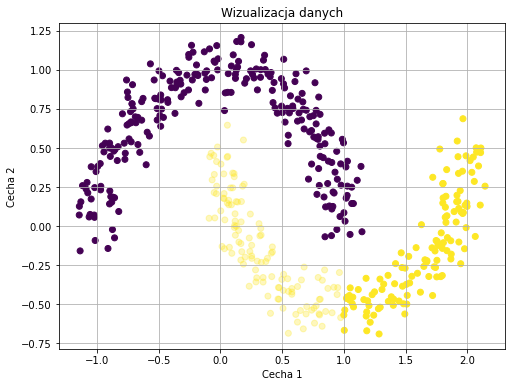

In [35]:
_, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y'], alpha=data['s'])
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.grid()
ax.set_title('Wizualizacja danych');

## Crisp SVM implementation

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse
from scipy.optimize import minimize
from numpy.random import RandomState
from itertools import product
from scipy.optimize import LinearConstraint


class CrispSVM(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, kernel='linear', degree=3, coef0=0, gamma=1,
                 max_samples=100, tol=None, max_iter=10, random_state=None, disp=False):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.max_samples = max_samples
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.disp = disp
        
        self.kernel_fun = self._get_kernel_fun_by_name(kernel)
        self.rs = RandomState(random_state)
        
        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, y):
        # replaces 0 labels with -1
        y = y.flatten()
        y = np.copy(y)
        y[y == 0] = -1

        # convert to dense array
        if issparse(X):
            X = X.A
            
        # sample data
        X, y = self._sample_xy(X, y)

        # minimization
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, np.inf) for _ in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        constraint2 = LinearConstraint(np.ones((X.shape[0],)), 0, self.C)
        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self.kernel_fun),
            bounds=alphas_bounds,
            constraints=(constraint1, constraint2),
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': self.disp}
        )
        alphas = res.x.ravel()

        # save results
        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X, self.kernel_fun)

        return self
    
    def _sample_xy(self, X, y):
        n_samples = min(X.shape[0], self.max_samples)
        sampled_X, _, sampled_y, _ = train_test_split(
            X, y,
            train_size=n_samples,
            stratify=y,
            random_state=self.rs
        )
        return sampled_X, sampled_y

    @staticmethod
    def _loss(v, X, ys, kernel_fun):
        alphas = v.flatten()
        n = alphas.size

        s = 0
        for i, j in product(range(n), range(n)):
            s += alphas[i]*alphas[j]*ys[i]*ys[j]*kernel_fun(X[i], X[j])
        return s - np.sum(alphas)

    @staticmethod
    def _calc_bias(alphas, ys, xs, kernel):
        n = xs.shape[0]
        outer_sum = 0
        for i in range(n):
            inner_sum_parts_generator = (alphas[j] * ys[j] * kernel(xs[i], xs[j]) for j in range(n))
            inner_sum = sum(inner_sum_parts_generator)
            outer_sum_part = ys[i] - inner_sum
            outer_sum += outer_sum_part
        return outer_sum / n
    
    def _get_kernel_fun_by_name(self, kernel_name):
        if kernel_name == 'linear':
            return self._kernel_linear
        elif kernel_name == 'poly':
            return self._kernel_poly
        elif kernel_name == 'rbf':
            return self._kernel_rbf
    
    def _kernel_linear(self, a, b):
        return a@b
    
    def _kernel_poly(self, a, b):
        return (a@b + self.coef0) ** self.degree
    
    def _kernel_rbf(self, a, b):
        diff = a-b
        magnitude = np.sqrt(diff@diff)
        return np.exp(-self.gamma*magnitude)

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self.kernel_fun, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result.ravel()

    def predict(self, X):
        return self.decision_function(X) > 0

## Crip SVM test

#### Learning

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

crisp_svm = make_pipeline(
    MinMaxScaler(),
    CrispSVM(kernel='poly', degree=3, coef0=1, C=1e10, max_samples=70, max_iter=400, tol=1e-20)
)

start = time()
crisp_svm.fit(data['x'], data['y'])
print(f'Fit time: {time()-start:.2f}')

Fit time: 270.16


#### Decision surface

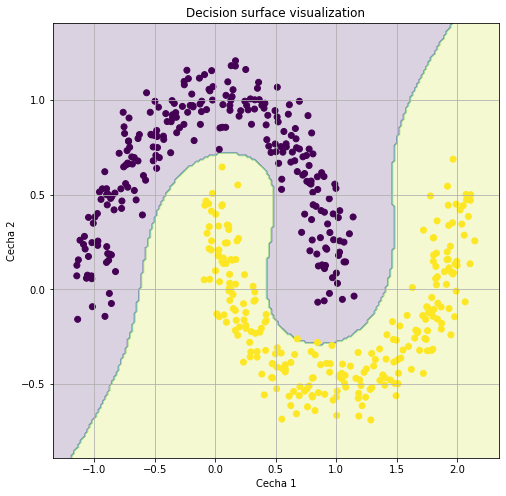

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

resolution = 200
margin = 0.2

x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

space = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
predictions_syn2 = crisp_svm.predict(np.dstack([*space]).reshape(-1, 2)).reshape(resolution, resolution)

ax.contourf(space[0], space[1], predictions_syn2, alpha=0.2)
ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y'])

ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.set_title(f'Decision surface visualization')
ax.grid()